In [26]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gzip
from utility import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
pylab.rcParams['figure.figsize'] = (40, 20)
sys.setrecursionlimit(10000)
conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5

down_sample_ratio = 16
learning_rate = 0.00001
epochs = 10
HiC_max_value = 100

In [28]:
# low_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr19_22.npy.gz', "r")) * down_sample_ratio
# high_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_original_chr19_22.npy.gz', "r"))
# low_resolution_samples_val = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr17_17.npy.gz', "r")) * down_sample_ratio
# N, d, w, h = low_resolution_samples.shape
# low_resolution_samples = low_resolution_samples[:, 0, :, :].reshape(N, w, h, d)
# high_resolution_samples = high_resolution_samples[:, 0, :, :].reshape(N, w, h, d)
low_resolution_samples, high_resolution_samples, cache = loadData(40, 40, 28, 28, root="../../")
low_resolution_samples = low_resolution_samples.reshape(-1, 40, 40, 1)
high_resolution_samples = high_resolution_samples.reshape(-1, 40, 40, 1)


Starting to load data...
expected:  17 17
actual: 17 17 289
expected:  17 17
actual: 17 17 289
expected:  17 16
actual: 17 16 272
expected:  17 16
actual: 17 16 272
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 12
actual: 17 12 204
expected:  17 12
actual: 17 12 204
expected:  17 11
actual: 17 11 187
expected:  17 11
actual: 17 11 187
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 6
act

actual: 10 6 60
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 3
actual: 10 3 30
expected:  10 3
actual: 10 3 30
expected:  10 4
actual: 10 4 40
expected:  10 4
actual: 10 4 40
expected:  10 2
actual: 10 2 20
expected:  10 2
actual: 10 2 20
expected:  10 3
actual: 10 3 30
expected:  10 3
actual: 10 3 30
expected:  10 10
actual: 10 10 100
expected:  10 10
actual: 10 10 100
expected:  10 10
actual: 10 10 100
expected:  10 10
actual: 10 10 100
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  1

finished loading data


In [29]:
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)

(20022, 40, 40, 1)
(20022, 40, 40, 1)


In [30]:
sample_size = low_resolution_samples.shape[-2]
padding = conv2d1_filters_size + conv2d2_filters_size + conv2d3_filters_size - 3
half_padding = padding // 2
output_length = sample_size - padding

print("Sample Size: %d"%(sample_size))
print("Padding: %d"%(padding))
print("Half Padding: %d"%(half_padding))
print("Output Length: %d"%(output_length))

Sample Size: 40
Padding: 12
Half Padding: 6
Output Length: 28


In [31]:
Y_new = high_resolution_samples[:, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding), 0]
Y_new = Y_new.reshape(Y_new.shape[0], -2)
X_new = low_resolution_samples
trainSize = 10000
Y_train = high_resolution_samples[:trainSize, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding), 0]
Y_train = Y_train.reshape(Y_train.shape[0], -2)
X_train = low_resolution_samples[:trainSize]

Y_val = high_resolution_samples[trainSize:, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding), 0]
Y_val = Y_val.reshape(Y_val.shape[0], -2)
X_val = low_resolution_samples[trainSize:]

In [32]:
print(X_new.shape)
print(Y_new.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(20022, 40, 40, 1)
(20022, 784)
(10000, 40, 40, 1)
(10000, 784)
(10022, 40, 40, 1)
(10022, 784)


In [65]:
tf.reset_default_graph()

Xtf = tf.placeholder(tf.float32, [None, sample_size, sample_size, 1])
ytf = tf.placeholder(tf.float32, [None, Y_new.shape[1]])

def myModel(Xtf,ytf):
    Wconv1 = tf.get_variable("Wconv1", [conv2d1_filters_size, conv2d1_filters_size, 1, conv2d1_filters_numbers])
    bconv1 = tf.get_variable("bconv1", [conv2d1_filters_numbers])
    Wconv2 = tf.get_variable("Wconv2", [conv2d2_filters_size, conv2d2_filters_size, conv2d1_filters_numbers, conv2d2_filters_numbers])
    bconv2 = tf.get_variable("bconv2", [conv2d2_filters_numbers])
    Wconv3 = tf.get_variable("Wconv3", [conv2d3_filters_size, conv2d3_filters_size, conv2d2_filters_numbers, conv2d3_filters_numbers])
    bconv3 = tf.get_variable("bconv3", [conv2d3_filters_numbers])
    
    a1 = tf.nn.conv2d(Xtf, Wconv1, strides=[1, 1, 1, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding='VALID')+ bconv2 
    h2 = tf.nn.relu(a2)
    a3 = tf.nn.conv2d(h2, Wconv3, strides=[1, 1, 1, 1], padding='VALID')+ bconv3 
    h3 = tf.nn.relu(a3)
    y_out = tf.reshape(h3, [-1, output_length*output_length])
    return y_out

y_out = myModel(Xtf,ytf)

total_loss = tf.losses.mean_squared_error(ytf,y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.GradientDescentOptimizer(5e-4)
train_step = optimizer.minimize(mean_loss)

In [66]:
pylab.rcParams['figure.figsize'] = (40, 20)
def run_model(session, predict, loss_val, Xd, yd,
              epochs=2, batch_size=64, print_every=100,
              training_steps=None, plot_losses=False):
    indicies = [(0,4000),(4000,8000),(8000,12000),(12000,16000),(16000,20022)]
    predictYs = []
    train_losses = []
    val_losses = []
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    training = [mean_loss,training_steps]
    validation = [mean_loss,predict]
    # counter 

    for e in range(epochs):
        train_loss = 0
        val_loss = 0
        val_index = indicies.pop(0)
        x_val = Xd[val_index[0]:val_index[1]]
        y_val = yd[val_index[0]:val_index[1]]
        x_train = np.array([]).reshape(0,40,40,1)
        y_train = np.array([]).reshape(0,784)
        for index in indicies:
            x_train = np.concatenate((x_train,Xd[index[0]:index[1]]))
            y_train = np.concatenate((y_train,yd[index[0]:index[1]]))
        indicies.append(val_index)
        train_size = y_train.shape[0]
        val_size = y_val.shape[0]
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(train_size/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%train_size
            end_idx = min(start_idx+batch_size,train_size)
            
            # create a feed dictionary for this batch
            feed_dict = {Xtf: x_train[start_idx:end_idx],
                         ytf: y_train[start_idx:end_idx],}
            # get batch size
            actual_batch_size = y_train[start_idx:end_idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step

            loss,_ = session.run(training,feed_dict=feed_dict)
            
            # aggregate performance stats
            train_loss +=loss*actual_batch_size
            
            # print every now and then
        for i in range(int(math.ceil(val_size/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%val_size
            end_idx = min(start_idx+batch_size,val_size)
            
            # create a feed dictionary for this batch
            feed_dict = {Xtf: x_val[start_idx:end_idx],
                         ytf: y_val[start_idx:end_idx],}
            # get batch size
            actual_batch_size = y_val[start_idx:end_idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step

            loss,_ = session.run(validation,feed_dict=feed_dict)
            
            # aggregate performance stats
            val_loss +=loss*actual_batch_size
        feed_dict = {Xtf: Xd,
                     ytf: yd,}
        y_out = session.run(predict,feed_dict = feed_dict)
        train_loss = train_loss/train_size
        val_loss = val_loss/val_size
#         print("Iteration {0}: with minibatch training loss = {1:.3g}"\
#                       .format(iter_cnt,loss))
        predictYs.append(y_out)
        print("Epoch {1}, train loss = {0:.3g},val loss = {2:.3g}"\
              .format(train_loss,e+1,val_loss))
#         if plot_losses:
#             plt.plot(losses)
#             plt.grid(True)
#             plt.title('Epoch {} Loss'.format(e+1))
#             plt.xlabel('minibatch number')
#             plt.ylabel('minibatch loss')
#             plt.show()
    return predictYs

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training')

        AllPredicted = run_model(sess,y_out,mean_loss,X_new,Y_new,30,64,100,train_step)


Training
Epoch 1, train loss = 1.49,val loss = 0.666
Epoch 2, train loss = 0.675,val loss = 0.148
Epoch 3, train loss = 0.578,val loss = 0.314
Epoch 4, train loss = 0.576,val loss = 0.27
Epoch 5, train loss = 0.302,val loss = 1.41
Epoch 6, train loss = 0.522,val loss = 0.473
Epoch 7, train loss = 0.604,val loss = 0.145
Epoch 8, train loss = 0.561,val loss = 0.311
Epoch 9, train loss = 0.566,val loss = 0.266
Epoch 10, train loss = 0.298,val loss = 1.39
Epoch 11, train loss = 0.516,val loss = 0.467
Epoch 12, train loss = 0.598,val loss = 0.144
Epoch 13, train loss = 0.556,val loss = 0.31
Epoch 14, train loss = 0.561,val loss = 0.264
Epoch 15, train loss = 0.296,val loss = 1.38
Epoch 16, train loss = 0.513,val loss = 0.462
Epoch 17, train loss = 0.594,val loss = 0.143
Epoch 18, train loss = 0.552,val loss = 0.309
Epoch 19, train loss = 0.558,val loss = 0.262
Epoch 20, train loss = 0.294,val loss = 1.38
Epoch 21, train loss = 0.51,val loss = 0.458
Epoch 22, train loss = 0.59,val loss = 0.1

In [67]:
print("number of contact maps: ", len(cache))
cacheIndex = 1
def reconstructFromIndex(cache, predicted, cacheIndex):
    sum_t = 0
    for i in range(cacheIndex):
        sum_t += cache[i][0]
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum_t:sum_t+N,:].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    #print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
def reconstructFromFeatures(low_resolution_samples, high_resolution_samples, predicted):
    height = 0
    width = 0
    size_dict = {}
    nss = np.zeros(24, dtype='int32')
    cacheIndex = 0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:, 6:34, 6:34,0]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y_new, cacheIndex)
            #ax = plt.subplot(1, 3, 1)
            #ax.imshow(lowReconstructedByIndex)   
            #ax = plt.subplot(1, 3, 2)
            #ax.imshow(predReconstructedByIndex)
            #ax = plt.subplot(1, 3, 3)
            #ax.imshow(highReconstructedByIndex)
            plt.show()
            cacheIndex += 1
            assert lowReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert lowReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            assert predReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert predReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            size_dict[(chr1, chr2)] = \
                (lowReconstructedByIndex, highReconstructedByIndex\
                 , predReconstructedByIndex)
            nss[chr1] = np.max([lowReconstructedByIndex.shape[0], nss[chr1]])

    width = height = int(np.sum(nss))
    print("H and W:", width, height)
    lowReconstructed = np.zeros((height, width) )
    highReconstructed = np.zeros((height, width))
    predReconstructed = np.zeros((height, width))
    cacheIndex=0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:,6:34, 6:34,0]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y_new, cacheIndex)
            lowReconstructedByIndex, highReconstructedByIndex, predReconstructedByIndex = size_dict[(chr1, chr2)]
            H = int(nss[:chr1].sum())
            W = int(nss[:chr2].sum())
            h, w = lowReconstructedByIndex.shape
            #print(chr1, chr2, H, W, h, w, lowReconstructedByIndex.shape)
            lowReconstructed[H:H+h, W:W+w] = lowReconstructedByIndex * 1.
            highReconstructed[H:H+h, W:W+w] = highReconstructedByIndex * 1.
            predReconstructed[H:H+h, W:W+w] = predReconstructedByIndex * 1.
            if chr1 != chr2:
                lowReconstructed[W:W+w, H:H+h] = lowReconstructedByIndex.T * 1.
                highReconstructed[W:W+w, H:H+h] = highReconstructedByIndex.T * 1.
                predReconstructed[W:W+w, H:H+h] = predReconstructedByIndex.T * 1.            
            cacheIndex += 1
    return lowReconstructed, highReconstructed, predReconstructed, size_dict, nss

number of contact maps:  276


In [68]:
predictedIndex = -1
lowReconstructed, highReconstructed, predReconstructed, size_dict, nss = reconstructFromFeatures(low_resolution_samples\
                                                                                           , high_resolution_samples\
                                                                                           , AllPredicted[predictedIndex])
chr1 = 5
chr2 = 6
H, W = (np.sum(nss[:chr1]), np.sum(nss[:chr2]))
h, w = size_dict[(chr1, chr2)][1].shape
a = size_dict[(chr1, chr2)][1]
b = highReconstructed[H:H+h, W:W+w]
print("Relative Error: ", rel_error(a, b))

H and W: 5460 5460
Relative Error:  0.0


Number of rows and columns: 1, 3


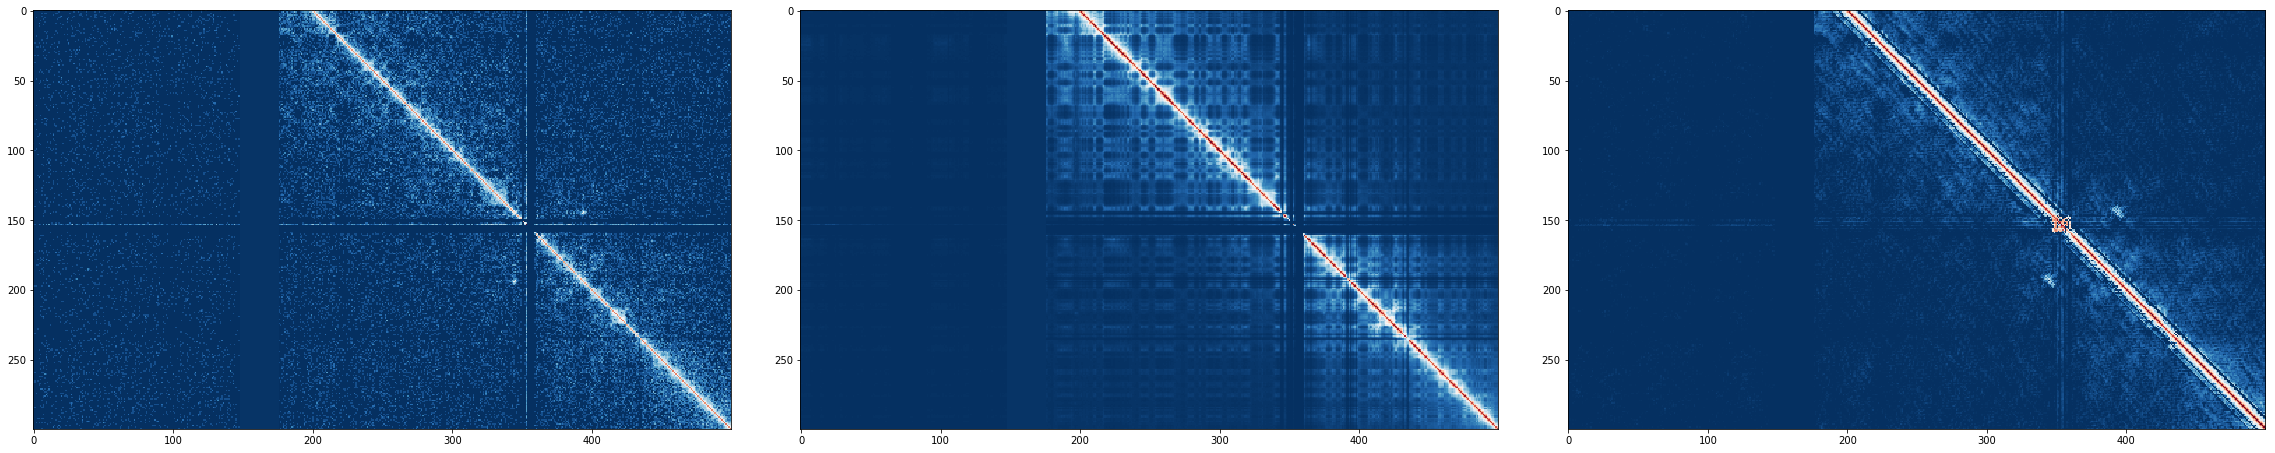

In [69]:
showImages([lowReconstructed[500:800, 300:800], highReconstructed[500:800, 300:800], predReconstructed[500:800, 300:800]])

In [37]:
a = np.random.rand(500, 6, 7)
blockSize = 500 // 5
allIndices = []
for i in range(5):
    x = [i for i in range(i*blockSize, (i+1)*blockSize)]
    allIndices.append(x)
trainIndices = []
for e in range(100):
    chosenIndex = e % 5
    for i in range(5):
        if i == chosenIndex:
            continue
        trainIndices.extend(allIndices[i])
        

In [57]:
indicies = [(0,4000),(4000,8000),(8000,11999),(12000,16000),(16000,20022)]
val_index = indicies.pop(0)
x_val = X_new[val_index[0]:val_index[1]]
y_val = Y_new[val_index[0]:val_index[1]]
print(y_val.shape)
x_train = np.array([]).reshape(0,40,40,1)
for index in indicies:
    x_train = np.concatenate((x_train,X_new[index[0]:index[1]]))
indicies.append(val_index)
print(x_train.shape)

(4000, 784)
(16021, 40, 40, 1)
